In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [10]:
def collect_experiment_to_df(fpath="expt_logs/"):
    #Reading all the experiments file
    expt_fname_list = glob.glob(fpath+"*.json")
    
    #Now we will create a dataframe out of it
    expt_metric_list = []
    for fname in expt_fname_list:
        #Loading the experiment json file
        with open(fname) as f:
            expt_json = json.load(f)
        
        #Next we will load the necessary metrics from json for analysis
        expt_metric_dict = dict(
                    num_nodes = expt_json["expt_args"]["num_nodes"],
                    num_samples = expt_json["expt_args"]["mix_samples"],
                    param_est_rel_err = expt_json["metric_dict"]["param_est_rel_err"],
                    shd = expt_json["metric_dict"]["shd"],
                    avg_js = expt_json["metric_dict"]["avg_js"],
                    
        )
        expt_metric_list.append(expt_metric_dict)
    
    #Now we will create a dataframe out of it
    expt_df = pd.DataFrame(expt_metric_list)
    return expt_df

## Plot utilities

In [56]:
#Defining the custom percentile function
def quantile25(x):
    return x.quantile(0.25)
def quantile75(x):
    return x.quantile(0.75)

[]

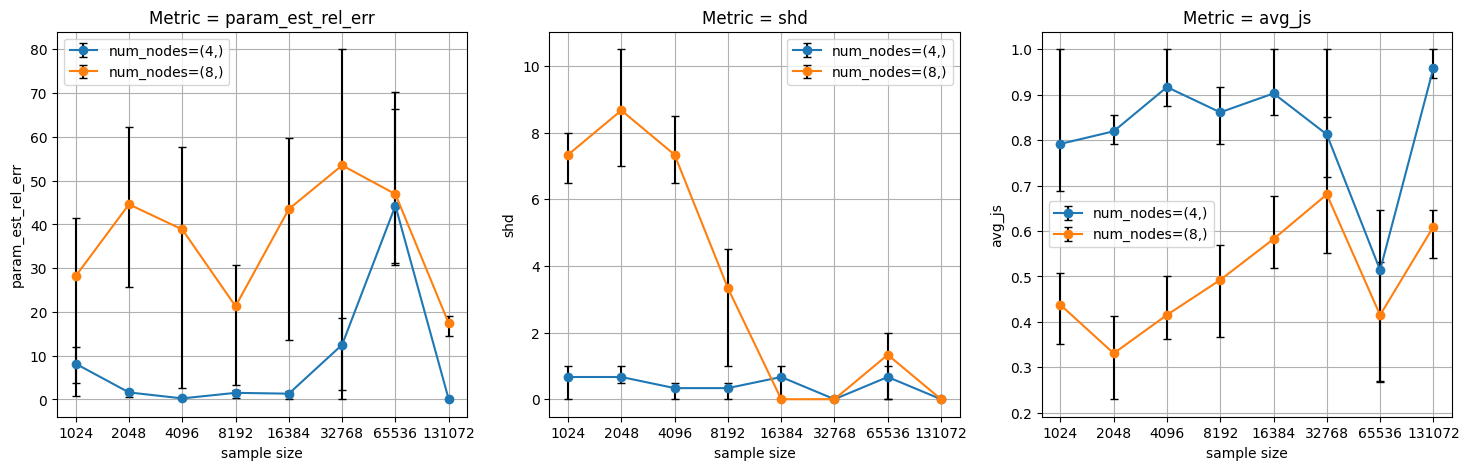

In [64]:
plot_metric_list = ["param_est_rel_err","shd","avg_js"]


plt.rcParams['figure.figsize'] = [6*len(plot_metric_list),5]
fig,ax = plt.subplots(nrows=1,ncols=len(plot_metric_list))



expt_df = collect_experiment_to_df(fpath="expt_logs/")



for num_node,node_df in expt_df.groupby(["num_nodes"]):
    #Getting the mean and std for this dataframe
    node_df_mean = node_df.groupby("num_samples").mean()
    node_df_std = node_df.groupby("num_samples").std()
    node_df_q25 = node_df.groupby("num_samples").aggregate(quantile25)
    node_df_q75 = node_df.groupby("num_samples").aggregate(quantile75)
    
    
    #Now plotting the variation across samples for each of the param
    for midx,metric in enumerate(plot_metric_list):
        sample_size = list(node_df_mean.index)
        metric_mean = np.array(node_df_mean[metric].tolist())
        metric_std = np.array(node_df_std[metric].tolist())
        q25_75 = [
                    metric_mean - np.array(node_df_q25[metric].tolist()),
                    np.array(node_df_q75[metric].tolist())-metric_mean
        ]
        
        
        #ax[midx].plot(range(len(sample_size)),metric_mean,)
        ax[midx].errorbar(range(len(sample_size)),
                              metric_mean,
                              yerr=q25_75,
                              capsize=3,
                              ecolor = "black",
                              fmt="-o",
                              label="num_nodes={}".format(num_node)
        )
        
        ax[midx].set_title("Metric = {}".format(metric))
        ax[midx].set_ylabel(metric)
        ax[midx].set_xlabel("sample size")
        ax[midx].set_xticks(range(len(sample_size)))
        ax[midx].set_xticklabels(sample_size)
        ax[midx].legend()
        ax[midx].grid(True)
        
plt.plot()

In [15]:
expt_df.head()

,num_nodes,num_samples,param_est_rel_err,shd,avg_js
0,8,2048,41.935353,5,0.292857
1,4,16384,3.622742,2,0.708333
2,4,1024,0.598380,0,1.000000
3,8,1024,76.923266,9,0.296875
4,4,65536,0.064792,0,1.000000


In [16]:
avg_expt_df.head()

param_est_rel_err       shd    avg_js
num_nodes num_samples                                       
4         1024                  8.170925  0.666667  0.791667
          2048                  1.611673  0.666667  0.819444
          4096                  0.250944  0.333333  0.916667
          8192                  1.516511  0.333333  0.861111
          16384                 1.327316  0.666667  0.902778

In [25]:
avg_expt_df.columns.tolist()

['param_est_rel_err', 'shd', 'avg_js']

In [20]:
avg_expt_df.loc[4]

,param_est_rel_err,shd,avg_js
num_samples,,,
1024,8.170925,0.666667,0.791667
2048,1.611673,0.666667,0.819444
4096,0.250944,0.333333,0.916667
8192,1.516511,0.333333,0.861111
16384,1.327316,0.666667,0.902778
32768,12.500828,0.000000,0.812500
65536,44.276730,0.666667,0.513889
131072,0.062155,0.000000,0.958333
